Using Colab cache for faster access to the 'skyview-an-aerial-landscape-dataset' dataset.
Path to dataset files: /kaggle/input/skyview-an-aerial-landscape-dataset
Total Categories: 15
Categories: ['Mountain', 'Highway', 'Airport', 'River', 'Agriculture', 'Parking', 'Railway', 'Lake', 'Residential', 'Port', 'City', 'Beach', 'Desert', 'Forest', 'Grassland']
       Category  Image_Count
0      Mountain          800
1       Highway          800
2       Airport          800
3         River          800
4   Agriculture          800
5       Parking          800
6       Railway          800
7          Lake          800
8   Residential          800
9          Port          800
10         City          800
11        Beach          800
12       Desert          800
13       Forest          800
14    Grassland          800


/tmp/ipython-input-3886097274.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Image_Count', data=df_counts, palette="viridis")


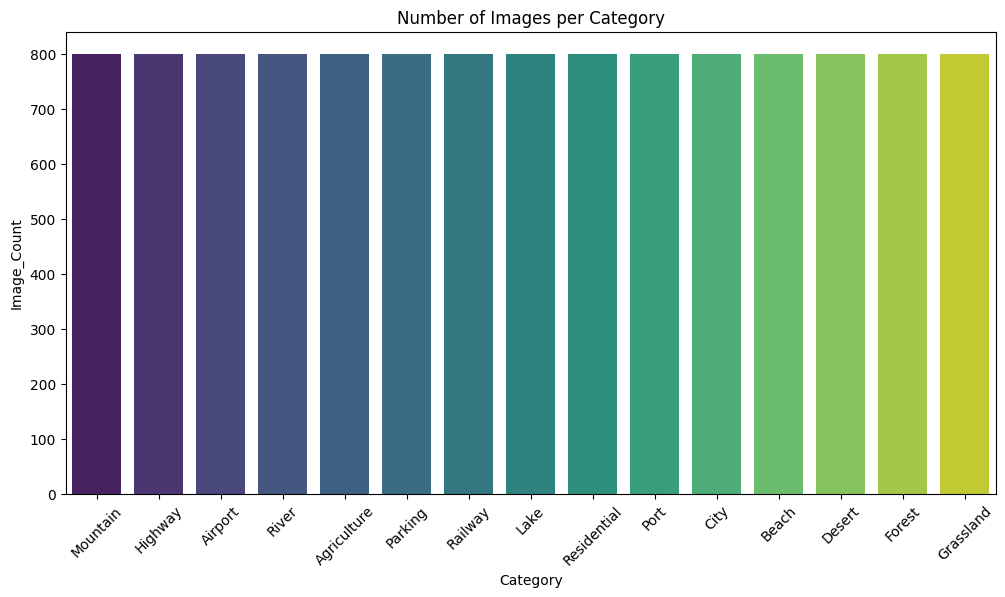

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import random
import numpy as np
from PIL import Image

# Download latest version
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")

print("Path to dataset files:", path)

# Use kagglehub downloaded path
dataset_path = os.path.join(path, "Aerial_Landscapes")

# Get list of categories (15 directories)
categories = os.listdir(dataset_path)
print("Total Categories:", len(categories))
print("Categories:", categories)

# Count number of images per category
img_counts = {cat: len(os.listdir(os.path.join(dataset_path, cat))) for cat in categories}

# Convert to DataFrame
df_counts = pd.DataFrame(list(img_counts.items()), columns=['Category', 'Image_Count'])
print(df_counts)

# Plot distribution
plt.figure(figsize=(12,6))
sns.barplot(x='Category', y='Image_Count', data=df_counts, palette="viridis")
plt.xticks(rotation=45)
plt.title("Number of Images per Category")
plt.show()


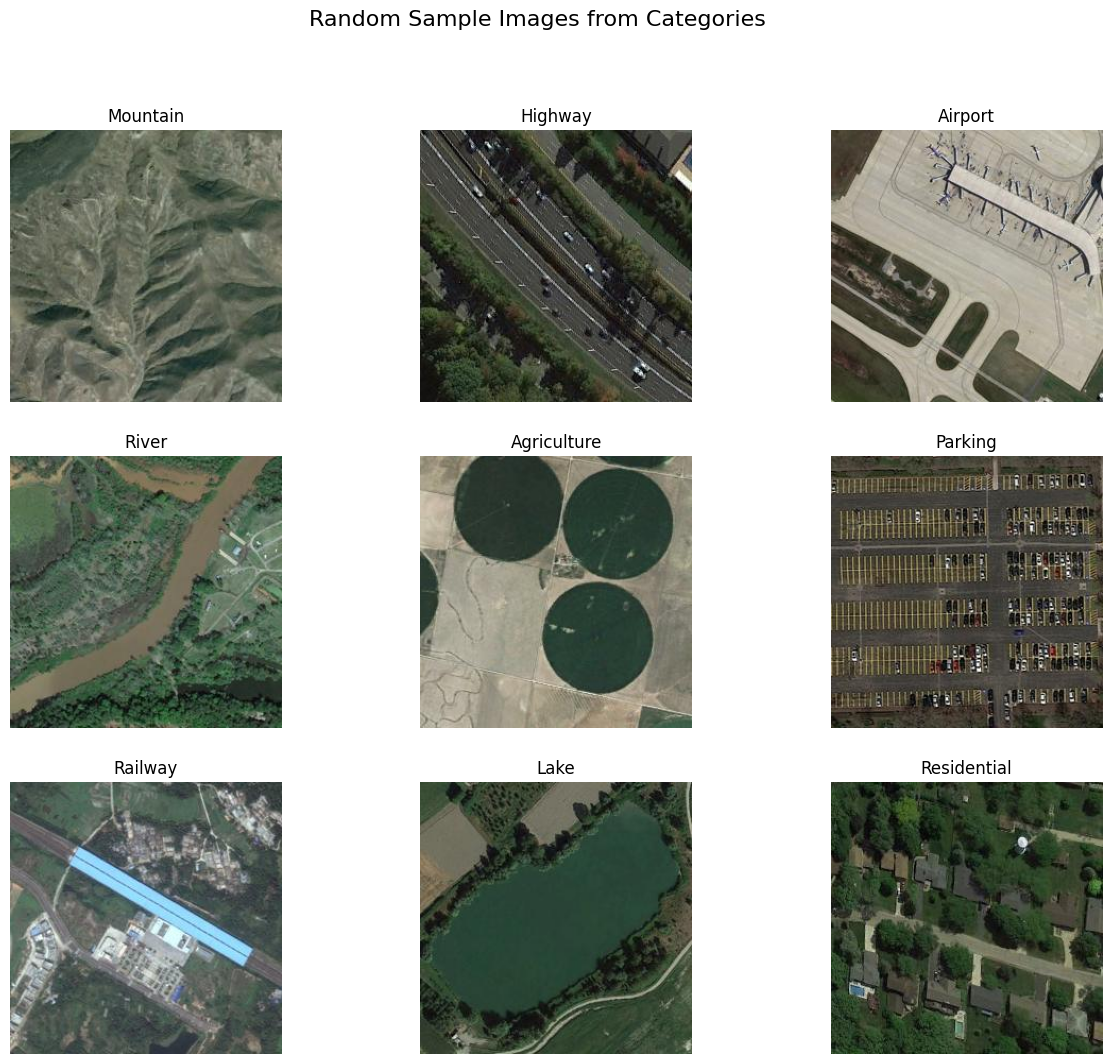

In [ ]:
# --- Step 4: Sample Images from Each Category ---
plt.figure(figsize=(15, 12))

for i, cat in enumerate(categories[:9]):  # display first 9 categories
    img_name = random.choice(os.listdir(os.path.join(dataset_path, cat)))
    img_path = os.path.join(dataset_path, cat, img_name)
    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis("off")

plt.suptitle("Random Sample Images from Categories", fontsize=16)
plt.show()



       Width  Height
count  750.0   750.0
mean   256.0   256.0
std      0.0     0.0
min    256.0   256.0
25%    256.0   256.0
50%    256.0   256.0
75%    256.0   256.0
max    256.0   256.0


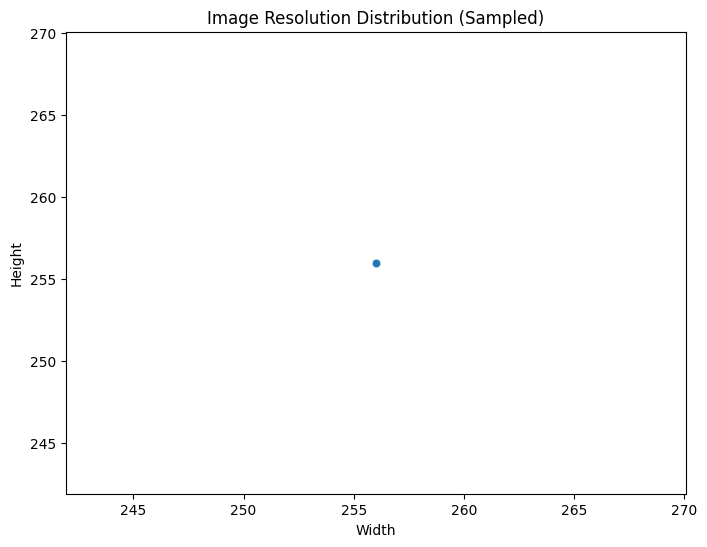

In [ ]:
# --- Step 5: Image Resolution Analysis ---
# Sample ~50 images to check resolution consistency
sizes = []
for cat in categories:
    sample_imgs = os.listdir(os.path.join(dataset_path, cat))[:50]
    for img_name in sample_imgs:
        img_path = os.path.join(dataset_path, cat, img_name)
        img = Image.open(img_path)
        sizes.append(img.size)

# Convert to DataFrame
df_sizes = pd.DataFrame(sizes, columns=["Width", "Height"])
print(df_sizes.describe())

# Scatter plot of resolutions
plt.figure(figsize=(8,6))
sns.scatterplot(x="Width", y="Height", data=df_sizes, alpha=0.6)
plt.title("Image Resolution Distribution (Sampled)")
plt.show()


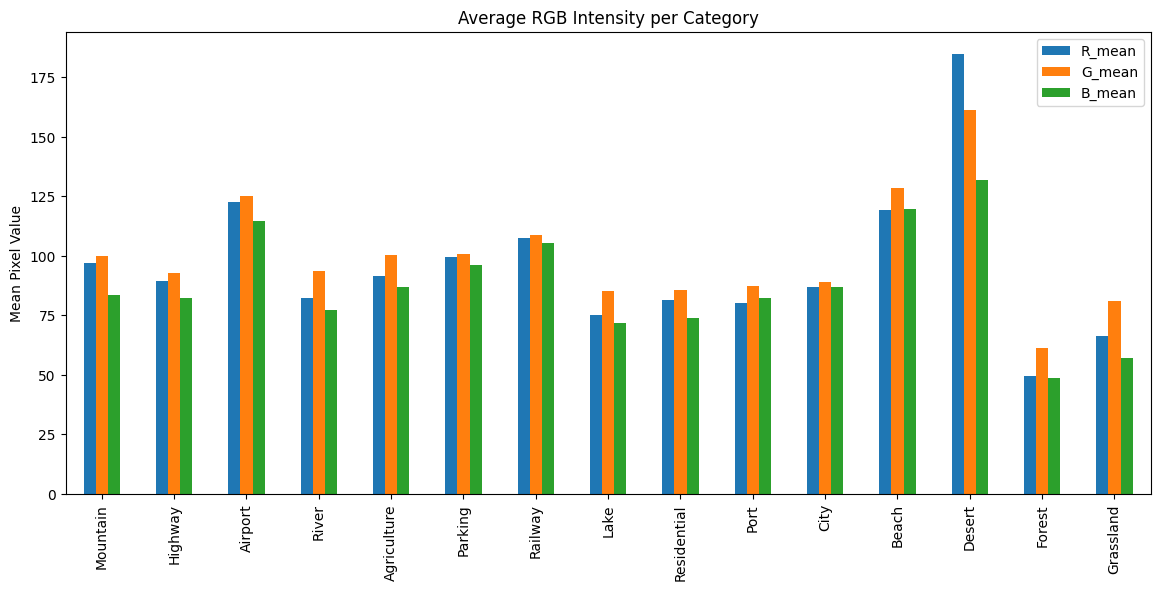

In [ ]:

# --- Step 6: Color Channel Analysis ---
# Compute mean RGB values per category (sample 50 images)
color_means = {}

for cat in categories:
    mean_r, mean_g, mean_b, count = 0, 0, 0, 0
    sample_imgs = os.listdir(os.path.join(dataset_path, cat))[:50]

    for img_name in sample_imgs:
        img_path = os.path.join(dataset_path, cat, img_name)
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img)

        mean_r += arr[:,:,0].mean()
        mean_g += arr[:,:,1].mean()
        mean_b += arr[:,:,2].mean()
        count += 1

    color_means[cat] = [mean_r/count, mean_g/count, mean_b/count]

df_colors = pd.DataFrame(color_means).T
df_colors.columns = ["R_mean", "G_mean", "B_mean"]

# Plot RGB intensities
df_colors.plot(kind='bar', figsize=(14,6))
plt.title("Average RGB Intensity per Category")
plt.ylabel("Mean Pixel Value")
plt.show()




In [ ]:

# --- Step 7: Potential Class Overlaps ---
# Not code, just reasoning
print("""
⚠️ Possible Visual Overlaps:
- Grassland vs Agriculture (open green areas)
- River vs Lake (both water bodies, only shape differs)
- City vs Residential (urban patterns, density difference)

These overlaps may cause confusion for ML models.
""")


⚠️ Possible Visual Overlaps:
- Grassland vs Agriculture (open green areas)
- River vs Lake (both water bodies, only shape differs)
- City vs Residential (urban patterns, density difference)

These overlaps may cause confusion for ML models.



Total corrupted images found: 0


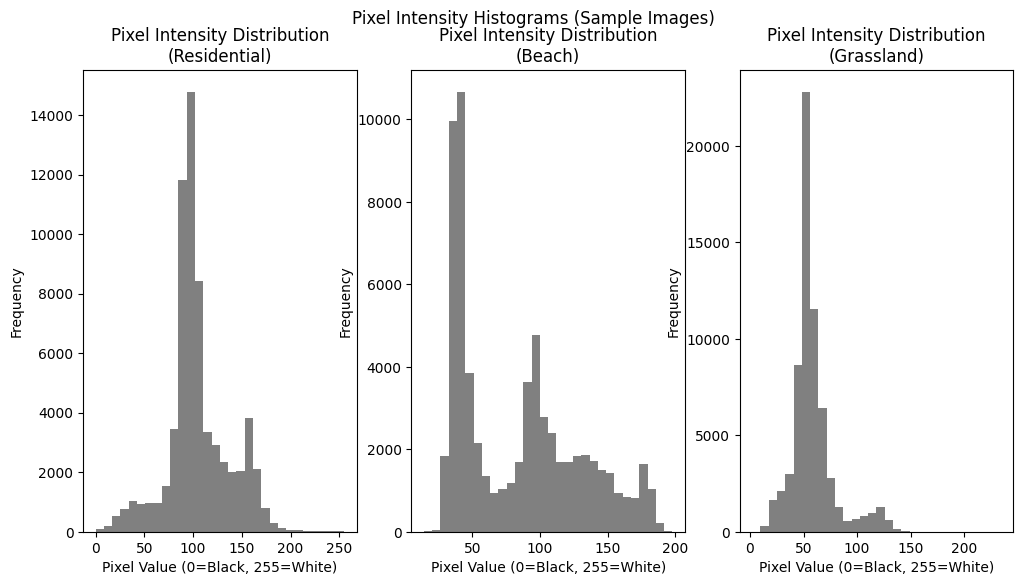


💡 Data Augmentation Strategy:
1. Since dataset has uniform 256x256 images, preprocessing is simple.
2. If class imbalance exists (check from df_counts), augment minority classes with:
   - Random flips (horizontal/vertical)
   - Small rotations (±15°)
   - Random crops & zoom
   - Color jitter (brightness, saturation, hue)
3. For aerial imagery, geometric transforms (rotations, flips) are especially useful,
   because orientation of landscapes does not change the class meaning.
4. Normalization (scaling pixel values to [0,1] or [-1,1]) should be applied before training CNNs.



In [ ]:
from collections import Counter

# --- Step 8: Outlier & Quality Check ---
# Check if any image is corrupted or cannot be opened
corrupted_files = []
for cat in categories:
    for img_name in os.listdir(os.path.join(dataset_path, cat)):
        img_path = os.path.join(dataset_path, cat, img_name)
        try:
            img = Image.open(img_path)
            img.verify()  # verify integrity
        except:
            corrupted_files.append(img_path)

print("Total corrupted images found:", len(corrupted_files))
if len(corrupted_files) > 0:
    print("Corrupted files:", corrupted_files)


# --- Step 9: Pixel Intensity Distribution ---
# Convert a random sample of images to grayscale and plot histograms
plt.figure(figsize=(12, 6))

for i, cat in enumerate(random.sample(categories, 3)):  # take 3 random categories
    img_name = random.choice(os.listdir(os.path.join(dataset_path, cat)))
    img_path = os.path.join(dataset_path, cat, img_name)
    img = Image.open(img_path).convert("L")  # grayscale

    arr = np.array(img).flatten()

    plt.subplot(1, 3, i+1)
    plt.hist(arr, bins=30, color='gray')
    plt.title(f"Pixel Intensity Distribution\n({cat})")
    plt.xlabel("Pixel Value (0=Black, 255=White)")
    plt.ylabel("Frequency")

plt.suptitle("Pixel Intensity Histograms (Sample Images)")
plt.show()


# --- Step 10: Augmentation Needs ---
print("""
💡 Data Augmentation Strategy:
1. Since dataset has uniform 256x256 images, preprocessing is simple.
2. If class imbalance exists (check from df_counts), augment minority classes with:
   - Random flips (horizontal/vertical)
   - Small rotations (±15°)
   - Random crops & zoom
   - Color jitter (brightness, saturation, hue)
3. For aerial imagery, geometric transforms (rotations, flips) are especially useful,
   because orientation of landscapes does not change the class meaning.
4. Normalization (scaling pixel values to [0,1] or [-1,1]) should be applied before training CNNs.
""")


Histograms tell us about contrast & brightness:
If values cluster near 0 → darker images.
If values cluster near 255 → brighter images.
Balanced spread → good contrast.
In aerial datasets, we usually see wide spread (since landscapes have varied textures).